## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim 


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.randn(3, 5)
y = torch.randn(5, 3)

In [ ]:
x @ y

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [ ]:
z = torch.empty(3, 3)

In [ ]:
torch.matmul(x, y, out=z)

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
    return x * (x > 0)

In [ ]:
assert torch.all(F.relu(x) == relu_forward(x))

In [ ]:
relu_forward(x)

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
s = torch.randn(3, 3)
s

In [ ]:
def elu_forward(x, alpha=1):
    ret = np.where(x > 0, x, alpha * (np.exp(x) - 1))
    return torch.tensor(ret)

    #return np.maximum(alpha * (np.exp(x) - 1), x)


In [ ]:
assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):
    return np.maximum(alpha * x, x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    return x * np.tanh(np.log(1 + np.exp(x)))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    return x / (1 + np.exp(-x))

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [10]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [11]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        sum_grad = 0
        #print(sum_grad)

        for param in filter(lambda x: x.grad is not None, group['params']):
            sum_grad = 0
            print(sum_grad)
            self._init_adam_buffer(param)
            d_param = param.grad
            buffer = self._get_adam_buffer(param)
            buffer = beta_2 * buffer + (1 - beta_2) * (d_param**2)

            sum_grad = beta_1 * sum_grad + (1 - beta_1) * d_param
            sum_grad_adj = sum_grad / (1 - beta_1)
            buffer_adj = buffer / (1 - beta_2)
            sum_grad_adj /= torch.sqrt(buffer + eps)
            param.add_(sum_grad_adj, alpha=-lr)
        sum_grad = 0

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `->torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer' not in param_state:
            param_state['adam_buffer'] = torch.zeros_like(param)

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

Загрузим данные и создадим даталоадеры:

In [2]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=128,
                                          shuffle=True, num_workers=2)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval, batch_size=128,
                                         shuffle=False, num_workers=2)

In [3]:
for i, j in train_dataloader:
    print(i.shape)
    break

torch.Size([128, 1, 28, 28])


Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [5]:
NUM_EPOCH = 10

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [13]:
def train_log_reg(model, criterion, optimizer, train_dataloader, eval_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    for epoch in range(NUM_EPOCH):
        print(f'Epoch {epoch + 1}')
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.

        with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
            for imgs, labels in train_dataloader:
                
                # Gradient decent
                optimizer.zero_grad()
                y_pred = model(imgs)
                #print(y_pred.shape, labels.shape)
                loss = criterion(y_pred, labels)
                loss.backward()
                optimizer.step()
                
                # updeting the loss
                train_loss += loss.item()
                train_size += y_pred.size(0)
                train_loss_log.append(loss.data / y_pred.size(0))

                _, pred_classes = torch.max(y_pred, 1)
                train_acc += (pred_classes == labels).sum().item()
                train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))
                prbar.set_description(
                    f"Loss: {round(train_loss, 4)} "
                    f"Accuracy: {round(train_acc * 100, 4)}")
                prbar.update(1)


            val_loss = 0.
            val_size = 0
            val_acc = 0.
            model.eval()
            with torch.no_grad():
                for imgs, labels in eval_dataloader:
                
                    pred = model(imgs)
                    loss = criterion(pred, labels)
                    val_loss += loss.item()
                    val_size += pred.size(0)

                    _, pred_classes = torch.max(pred, 1)
                    val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

Initialisation of the weights

In [199]:
def my_weights(m):
    n_in = 784
    n_out = 10
    weights = torch.Tensor(n_out, n_in).uniform_(-1, 1) * ((6./(n_in + n_out)**(1/2)))
    intercept = torch.Tensor(1, 10).uniform_(-1, 1) * ((6./(n_in + n_out)**(1/2)))
    if type(m) == nn.Linear:
        m.weight.data = weights
        m.bias.data = intercept

Model

In [200]:
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10), 
        nn.Softmax()
)
model.apply(my_weights)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=None)
)

In [12]:
for ims, _ in train_dataloader:
    x = model(ims)
    print(x.shape)
    break

torch.Size([128, 10])


Trainig modula of the model

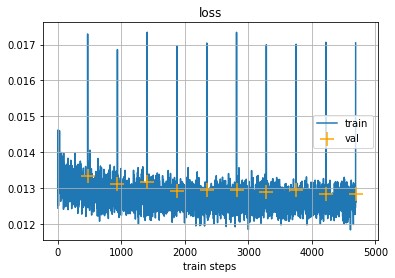

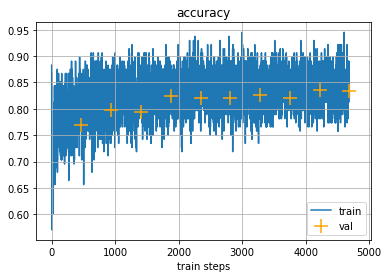

Train loss: 0.012639293885231018
Train acc: 0.84375
Val loss: 0.012856045377254486
Val acc: 0.8333


In [11]:
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_log_reg(model, criterion, optimizer, train_dataloader, eval_dataloader)

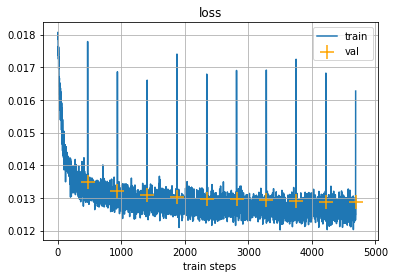

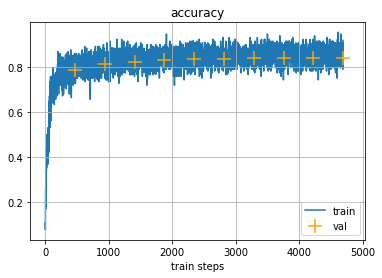

Train loss: 0.012641935125986735
Train acc: 0.8556166666666667
Val loss: 0.012881095051765441
Val acc: 0.8407


In [10]:
import torch.optim.adam 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-13)
criterion = nn.CrossEntropyLoss()

train_log_reg(model, criterion, optimizer, train_dataloader, eval_dataloader)

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента

===>>> изначально оценка, которую дает адам на самом деле смещена, но потом мы корректируем  эту оценку на бету, таким образом она становится несмещенной. Упрощая, формула, с помощью которой мы оцениваем второй момент в при взятии мат ожидания дает оценку со смещением на бету, потом это смещение корректируется и мы получаем несмещенну. оценку 


* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

===>>> Где-то на 12й - 15й эпохе модель начинает переобучаться, так как начиная с этого момента валидационная accuracy начинает скакать, то увкличивается, то понижается. Модель начинает подгоняться под обучающую выбрку

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [3]:
NUM_EPOCH = 10

In [14]:
def train(model, criterion, optimizer, train_dataloader, eval_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            
            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in eval_dataloader:
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)



## Linear model

In [15]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.linear = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 10, bias=True),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model_1 = FirstModel()

In [16]:
for ims, _ in train_dataloader:
    x = model_1(ims)
    print(x.shape)
    break

torch.Size([128, 10])


### SGD

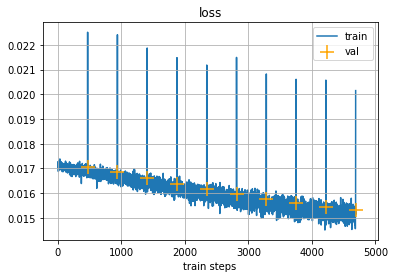

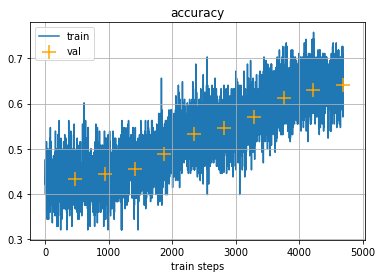

Train loss: 0.015204376111427944
Train acc: 0.63865
Val loss: 0.015327012181282044
Val acc: 0.6406


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.5)

train(model_1, criterion, optimizer, train_dataloader, eval_dataloader)

### RMSprop

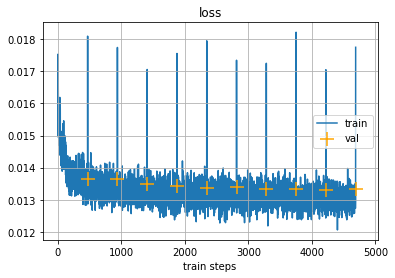

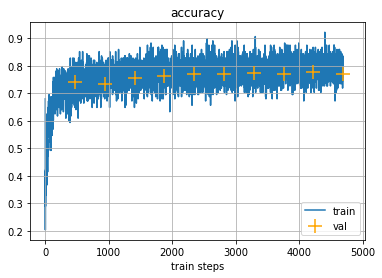

Train loss: 0.013031237506866454
Train acc: 0.7938333333333333
Val loss: 0.013345735239982604
Val acc: 0.77


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_1.parameters(), lr=0.001, momentum=0.5)

train(model_1, criterion, optimizer, train_dataloader, eval_dataloader)

## VGG-like model

In [5]:
second_model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(2, 2), padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=(2, 2), padding=1),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, kernel_size=(2, 2), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=(2, 2), padding=1),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10),
    nn.Softmax()
)


In [6]:
for ims, _ in train_dataloader:
    print(ims.shape)
    x = second_model(ims)
    print(x.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


### SGD

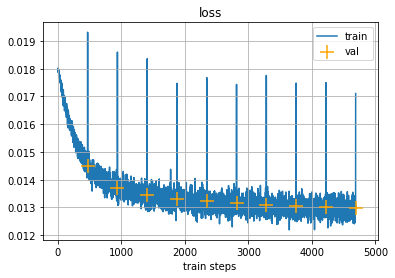

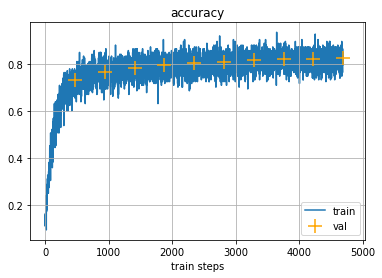

Train loss: 0.012944521242380142
Train acc: 0.8208166666666666
Val loss: 0.012975624835491181
Val acc: 0.8276


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9)

train(second_model, criterion, optimizer, train_dataloader, eval_dataloader)

### RMSprop

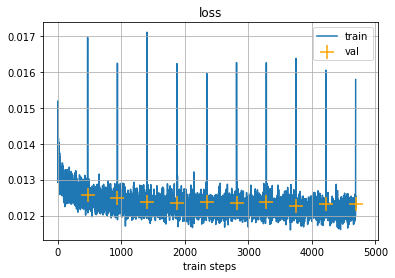

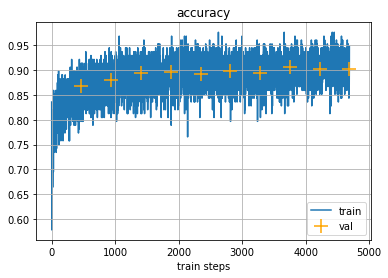

Train loss: 0.012156886897484462
Train acc: 0.9057833333333334
Val loss: 0.012320709574222564
Val acc: 0.9018


In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(second_model.parameters(), lr=0.001, momentum=0.9)

train(second_model, criterion, optimizer, train_dataloader, eval_dataloader)

### Model 3

In [24]:
class ResNetLikeNN(nn.Module):
    def __init__(self):
        super(ResNetLikeNN, self).__init__()
        self.module_1 = nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=5, padding = 2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        torch.nn.Conv2d(32, 1, kernel_size=5, padding = 2),
        )

        self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10),  
        nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.module_1(x) + x
        x = self.linear(x)
        return x 
model_3 = ResNetLikeNN()

In [26]:
for ims, _ in train_dataloader:
    x = model_3(ims)
    print(x.shape)
    break
model_3

torch.Size([128, 10])


ResNetLikeNN(
  (module_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (linear): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Softmax(dim=-1)
  )
)

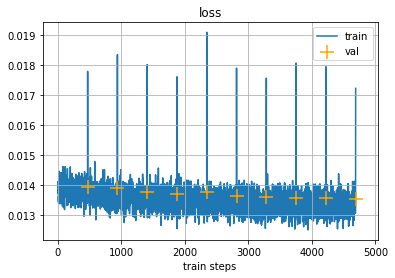

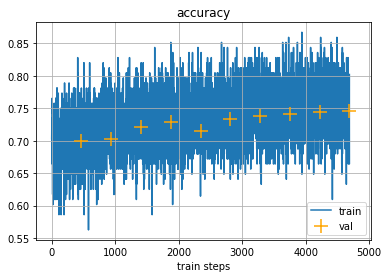

Train loss: 0.013349342552820841
Train acc: 0.7537
Val loss: 0.013554366958141327
Val acc: 0.7452


In [206]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)

train(model_3, criterion, optimizer, train_dataloader, eval_dataloader)

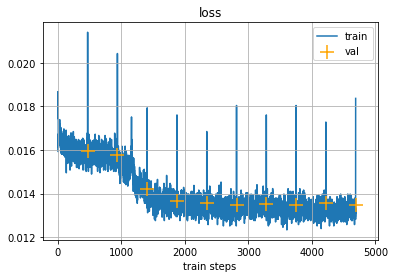

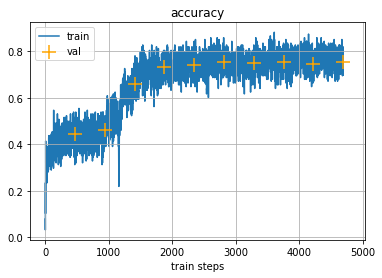

Train loss: 0.013255581565697987
Train acc: 0.7653333333333333
Val loss: 0.01348412710428238
Val acc: 0.7537


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_3.parameters(), lr=0.0008, momentum=0.8)

train(model_3, criterion, optimizer, train_dataloader, eval_dataloader)

In [ ]:
Очевидно преимущество сверточных сетей, ибо они позволяют более точно обучить модель, так как конструкция позволяет более эффективно обрабатывать входную информацию. Именно поэтому VGG и ResNet дает лучше результат, чем Linear. Более того если сравнивать методы оптимизации, то RMSprop дает намного более качественный результат, чем SGD, так как позволяет учитывать общую траекторию градиентного спуска, а также подстраивать скорость обучения (learning rate) в зависимости от обучения. Также RMSprop препятствует занулению параметров 


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [106]:
x = np.linspace(0, 20, 1000) 
x_bias = x + np.random.normal(0, 2.3, 1000)
y_1 = np.exp(x)
y_2 = np.log(x)
y_3 = 0.5 * x
y = [y_1, y_2, y_3]

In [107]:
beta = (x_bias.T @ x_bias)**(-1) * x_bias.T @ y_3

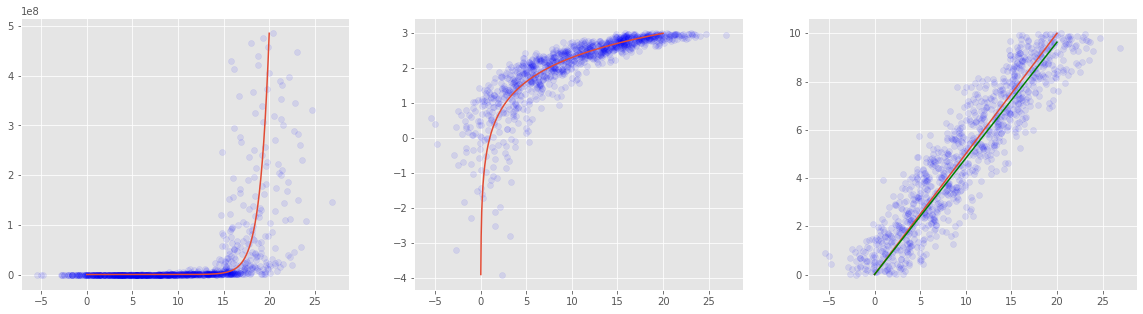

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), )
for i in [0, 1, 2]:
    axes[i].plot(x, y[i])
    axes[i].scatter(x_bias, y[i], alpha=0.09, color='blue')
    if i == 2: axes[i].plot(x, beta*x, color='green') 

None

In [125]:
teta = np.linspace(0.001, 3, 8)
teta = np.flip(teta)
teta

array([3.00000000e+00, 2.57157143e+00, 2.14314286e+00, 1.71471429e+00,
       1.28628571e+00, 8.57857143e-01, 4.29428571e-01, 1.00000000e-03])

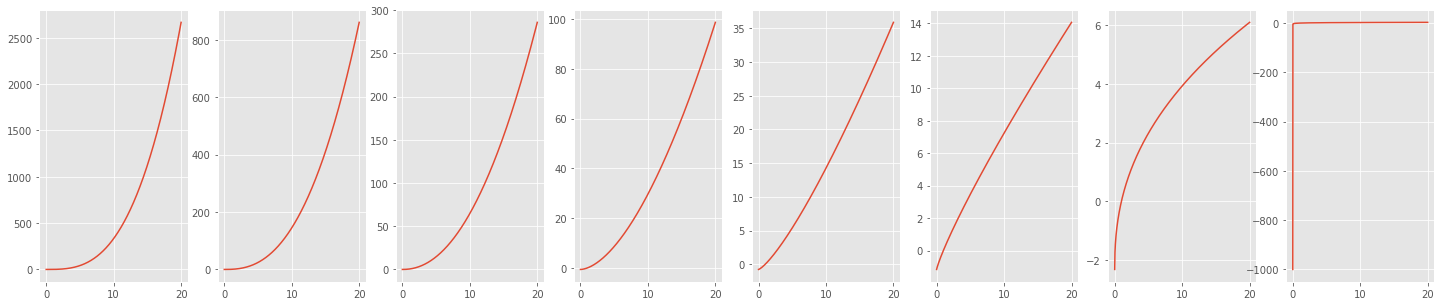

In [126]:
fig, axes = plt.subplots(1, len(teta), figsize=(25, 5))#, sharex=True, sharey=True)
for i in range(len(teta)):
    z = (x**teta[i] - 1)/teta[i]
    axes[i].plot(x, z)
None

In [5]:
x = np.linspace(-10, 10, 1000)
f1 = np.sin(x)
f2 = np.cos(x)
f = (f1, f2)

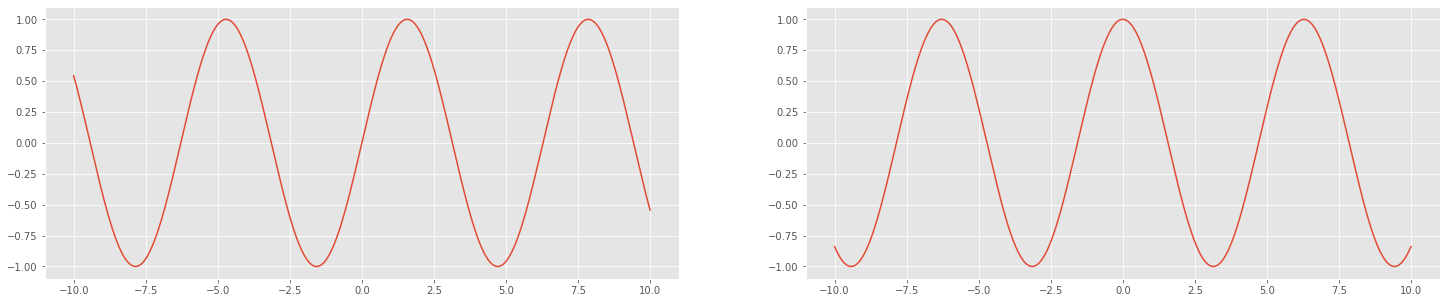

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(25, 5))#, sharex=True, sharey=True)
for i in [0, 1]:
    axes[i].plot(x, f[i])
None